In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
!mkdir data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

A subdirectory or file data already exists.


## Classifier

In [4]:
class Standard(nn.Module):
    def __init__(self, in_dim, h1_dim, h2_dim, out_dim) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
        self.l1 = nn.Linear(in_dim, h1_dim)
        self.l2 = nn.Linear(h1_dim, h2_dim)
        self.l3 = nn.Linear(h2_dim, out_dim)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.softmax(x)
        
        return x
    
    
in_dim = 28*28
h1_dim = 100
h2_dim = 100
out_dim = len(trainset.classes)
model = Standard(in_dim, h1_dim, h2_dim, out_dim)

In [5]:
def score(y_pred, y_true):
    winners = y_pred.argmax(dim=1)
    return (winners == y_true).sum() / winners.size(0)

<ipython-input-4-231b969a3cc4>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


EPOCH	 1
Train Loss:	 1.6343881036681154
Train Accuracy	 0.8411847
Val Loss:	 1.5576930987607143
Val Accuracy	 0.9076433
---------------------------
EPOCH	 2
Train Loss:	 1.5473174503617195
Train Accuracy	 0.9172108
Val Loss:	 1.5352262258529663
Val Accuracy	 0.93013537
---------------------------
EPOCH	 3
Train Loss:	 1.528949624185623
Train Accuracy	 0.9348181
Val Loss:	 1.5278467327166514
Val Accuracy	 0.93550956
---------------------------
EPOCH	 4
Train Loss:	 1.5194806797163827
Train Accuracy	 0.94319695
Val Loss:	 1.5184685151288464
Val Accuracy	 0.9451632
---------------------------
EPOCH	 5
Train Loss:	 1.5126850555446356
Train Accuracy	 0.94912714
Val Loss:	 1.5141265073399635
Val Accuracy	 0.94765127
---------------------------
EPOCH	 6
Train Loss:	 1.5089100894134944
Train Accuracy	 0.95302504
Val Loss:	 1.5069517937435466
Val Accuracy	 0.95461786
---------------------------
EPOCH	 7
Train Loss:	 1.5055301829950134
Train Accuracy	 0.9567564
Val Loss:	 1.5072092994762833
Val

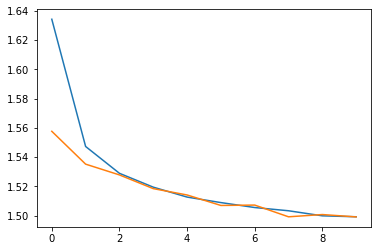

In [6]:
in_dim = 28*28
h1_dim = 100
h2_dim = 100
out_dim = len(trainset.classes)
model = Standard(in_dim, h1_dim, h2_dim, out_dim)


n_epochs = 10
learning_rate = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(1, n_epochs + 1):
    print('EPOCH\t', epoch)
    batch_train_losses = []
    batch_val_losses = []
    batch_train_acc = []
    batch_val_acc = []
    
    for x_batch, y_batch in trainloader:
        y_onehot = nn.functional.one_hot(y_batch, num_classes=10).float()
        
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_onehot)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())
        batch_train_acc.append(score(y_pred, y_batch))
        
    train_losses.append(np.mean(batch_train_losses))
    train_acc.append(np.mean(batch_train_acc))
    
    print('Train Loss:\t', train_losses[-1])
    print('Train Accuracy\t', train_acc[-1])
        
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            y_onehot = nn.functional.one_hot(y_batch, num_classes=10).float()
        
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_onehot)
            
            batch_val_losses.append(loss.item())
            batch_val_acc.append(score(y_pred, y_batch))
        
        val_losses.append(np.mean(batch_val_losses))
        val_acc.append(np.mean(batch_val_acc))
        
    print('Val Loss:\t', val_losses[-1])
    print('Val Accuracy\t', val_acc[-1])
    print('---------------------------')

fig, ax = plt.subplots()
ax.plot(np.arange(epoch), train_losses)
ax.plot(np.arange(epoch), val_losses)
plt.show()

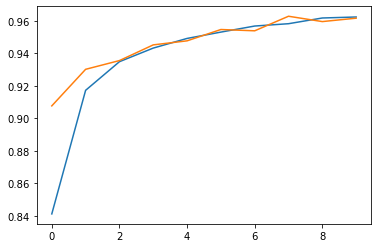

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(epoch), train_acc)
ax.plot(np.arange(epoch), val_acc)
plt.show()

In [8]:
y_batch

tensor([7, 0, 4, 2, 0, 7, 6, 6, 2, 1, 1, 8, 0, 9, 7, 9])

In [9]:
model(x_batch).argmax(dim=1)

<ipython-input-4-231b969a3cc4>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


tensor([7, 0, 4, 2, 0, 7, 6, 6, 2, 1, 1, 8, 0, 9, 7, 9])

## Autoencoder

## Normal

In [20]:
class Encoder(nn.Module):
    def __init__(self, in_dim, h1_dim, enc_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.l1 = nn.Linear(in_dim, h1_dim)
        self.l2 = nn.Linear(h1_dim, enc_dim)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        
        return x
    

In [26]:
class Decoder(nn.Module):
    def __init__(self, in_dim, h1_dim, out_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
        self.l1 = nn.Linear(in_dim, h1_dim)
        self.l2 = nn.Linear(h1_dim, out_dim)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        
        return x.reshape(-1, 1, 28, 28)

In [77]:
in_dim = 28*28
h_dim = 128
enc_dim = 10

encoder = Encoder(in_dim, h_dim, enc_dim)
decoder = Decoder(enc_dim, h_dim, in_dim)

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
lr = 1e-3
optimizer = torch.optim.Adam(model_parameters, lr=lr)

loss_fn = nn.MSELoss()
n_epochs = 100

losses = []
for epoch in range(1, n_epochs+1):
    print('EPOCH', epoch)
    batch_losses = []
    for x_batch, y_batch in trainloader:
        latent = encoder(x_batch)
        out = decoder(latent)
        
        loss = loss_fn(out, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())

    losses.append(np.mean(batch_losses))
    print('batch loss\t', losses[-1])

EPOCH 1
batch loss	 0.9257082784735063
EPOCH 2
batch loss	 0.9253561663856384
EPOCH 3
batch loss	 0.925353330907537
EPOCH 4
batch loss	 0.925354155967993
EPOCH 5
batch loss	 0.9253544299078903
EPOCH 6
batch loss	 0.9253532449955116
EPOCH 7
batch loss	 0.9253539307031042
EPOCH 8
batch loss	 0.9253507158014057
EPOCH 9
batch loss	 0.9253526943197636
EPOCH 10
batch loss	 0.9253537387990239
EPOCH 11
batch loss	 0.9253522969131023
EPOCH 12
batch loss	 0.9253525352045926
EPOCH 13
batch loss	 0.9253515464537687
EPOCH 14
batch loss	 0.9253525028604943
EPOCH 15
batch loss	 0.925350187874552
EPOCH 16
batch loss	 0.9253514952369845
EPOCH 17
batch loss	 0.9253556298802911
EPOCH 18
batch loss	 0.9253555278915332
EPOCH 19
batch loss	 0.925355872111534
EPOCH 20
batch loss	 0.925355453989399
EPOCH 21
batch loss	 0.9253552772724298
EPOCH 22
batch loss	 0.9253518717375391
EPOCH 23
batch loss	 0.9253546378251586
EPOCH 24
batch loss	 0.9253531058968257
EPOCH 25
batch loss	 0.9253511909864096
EPOCH 26
batch

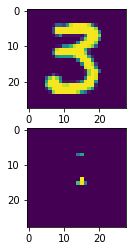

In [78]:
for x, y in valloader:
    latent = encoder(x)
    out = decoder(latent)
    
    fig, ax = plt.subplots(2)
    ax[0].imshow(x[0][0])
    ax[1].imshow(out[0][0].detach().numpy())
    
    # fig, ax = plt.subplots(10, 2, figsize=(2,10))
    # for n in range(10):
    #     ax[n][0].imshow(x[n][0])
    #     ax[n][1].imshow(out[n][0].detach().numpy())
    # plt.tight_layout()
    break

## Convolutional

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self

# Drawings

In [30]:
img_dim = 28
cats = np.load('data/quickdraw/full_numpy_bitmap_cat.npy').reshape(-1, img_dim, img_dim)
dogs = np.load('data/quickdraw/full_numpy_bitmap_dog.npy').reshape(-1, img_dim, img_dim)

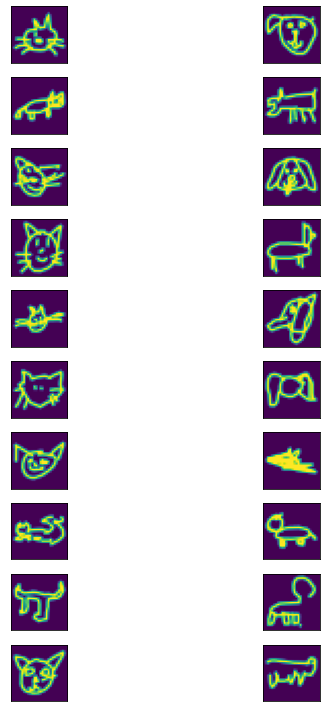

In [47]:
n_pics = 10
fig, axs = plt.subplots(n_pics, 2, figsize=(10,10))
for i in range(n_pics):
    axs[i][0].imshow(cats[i])
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    
    axs[i][1].imshow(dogs[i])
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])

plt.tight_layout()

In [64]:
n_cats = cats.shape[0]
n_dogs = dogs.shape[0]

x = np.concatenate((cats, dogs))
y = np.concatenate((np.zeros(n_cats), np.ones(n_dogs)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1, shuffle=True, random_state=69)

trainloader = torch.utils.data.DataLoader((x_train, y_train), batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader((x_test, y_test), batch_size=64, shuffle=True)

# 
